## 🧾 1. Introduction

This notebook analyses the Diabetes 130-US Hospitals dataset from the UCI Machine Learning Repository. The primary goal is to analyze patient readmission patterns and identify key predictors using Decision Tree model.

Dataset Source: UCI ML Repository (ID: 296)  
Domain: Healthcare  
Focus: 30-day hospital readmission for diabetic 

## 📦 2. Dataset Import

We use the cleaned dataset from EDA for this model building.

In [1]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('df_filtered_first_encounter_mapped.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

Dataset loaded successfully!
Shape: (59094, 121)


,Unnamed: 0,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,diag_3_category_Mental Disorders,diag_3_category_Musculoskeletal System,diag_3_category_Neoplasms,diag_3_category_Nervous System and Sense Organs,diag_3_category_Pregnancy and Childbirth,diag_3_category_Respiratory System,diag_3_category_Skin and Subcutaneous Tissue,diag_3_category_Supplementary Factors (V codes),diag_3_category_Symptoms and Ill-Defined Conditions,diag_3_category_Unknown
0,0,8,13,68,2,28,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
1,1,9,12,33,3,18,0,0,0,8,...,0,0,0,0,0,1,0,0,0,0
2,2,4,1,51,0,8,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
3,3,6,7,62,0,11,0,0,0,7,...,0,0,1,0,0,0,0,0,0,0
4,4,4,7,60,0,15,0,1,0,8,...,0,0,0,0,0,0,0,0,0,0


## 🔍 3. Model Building

**Prepare Data**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Separate the features (X) from the target variable (y).
# 'readmitted_flag' is what we want to predict.
X = df.drop("readmitted_flag", axis=1)
y = df["readmitted_flag"]

# Split the data into a training set (80%) and a testing set (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✓ Data split into training and testing sets.")

✓ Data split into training and testing sets.


**Build Model**

In [3]:
# Initialize the Decision Tree Classifier.
# We set 'max_depth=5' to keep the tree from getting too complex and easier to visualize.
clf = DecisionTreeClassifier(max_depth=5, random_state=42)


**Model Training & Prediction**

In [4]:
from sklearn.tree import DecisionTreeClassifier

# --- Model Training ---
dt_classifier = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,  # Limiting depth for interpretability and avoiding overfitting
    random_state=42
)

# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

print("Decision Tree Model Training Complete.")

# --- Prediction ---
Y_pred = dt_classifier.predict(X_test)

Decision Tree Model Training Complete.


**Evaluation & Feature Importance**

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Evaluation ---
print("\n--- Model Performance on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, Y_pred):.4f}")

# Classification Report
print("\nClassification Report:")
# Note: Target names 0='Not Readmitted', 1='Readmitted'
print(classification_report(y_test, Y_pred, target_names=['Not Readmitted', 'Readmitted']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, Y_pred)
print("\nConfusion Matrix (Rows=True, Cols=Predicted):\n", conf_matrix)


# --- Feature Importance ---
feature_importances = pd.Series(
    dt_classifier.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))


--- Model Performance on Test Set ---
Accuracy: 0.8546

Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.86      1.00      0.92     10085
    Readmitted       0.59      0.03      0.06      1734

      accuracy                           0.85     11819
     macro avg       0.72      0.51      0.49     11819
  weighted avg       0.82      0.85      0.79     11819


Confusion Matrix (Rows=True, Cols=Predicted):
 [[10046    39]
 [ 1679    55]]

Top 10 Most Important Features:
number_inpatient                                                                                                0.551212
discharge_disposition_name_Expired                                                                              0.118396
discharge_disposition_name_Discharged/transferred to another rehab fac including rehab units of a hospital .    0.104895
Unnamed: 0                                                                                                

✓ Decision tree model trained successfully!

Model Accuracy: 0.85


[Text(0.5653409090909091, 0.9166666666666666, 'number_inpatient <= 0.5\ngini = 0.249\nsamples = 47275\nvalue = [40382, 6893]\nclass = Not Readmitted'),
 Text(0.2897727272727273, 0.75, 'discharge_disposition_name_Discharged/transferred to another rehab fac including rehab units of a hospital . <= 0.5\ngini = 0.206\nsamples = 37518\nvalue = [33136, 4382]\nclass = Not Readmitted'),
 Text(0.4275568181818182, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'discharge_disposition_name_Discharged to home <= 0.5\ngini = 0.198\nsamples = 36654\nvalue = [32562.0, 4092.0]\nclass = Not Readmitted'),
 Text(0.06818181818181818, 0.4166666666666667, 'discharge_disposition_name_Expired <= 0.5\ngini = 0.252\nsamples = 13407\nvalue = [11428, 1979]\nclass = Not Readmitted'),
 Text(0.045454545454545456, 0.25, 'Unnamed: 0 <= 42398.0\ngini = 0.264\nsamples = 12655\nvalue = [10676.0, 1979.0]\nclass = Not Readmitted'),
 Text(0.022727272727272728, 0.08333333333333333, 'gini = 0.282\nsamples = 94

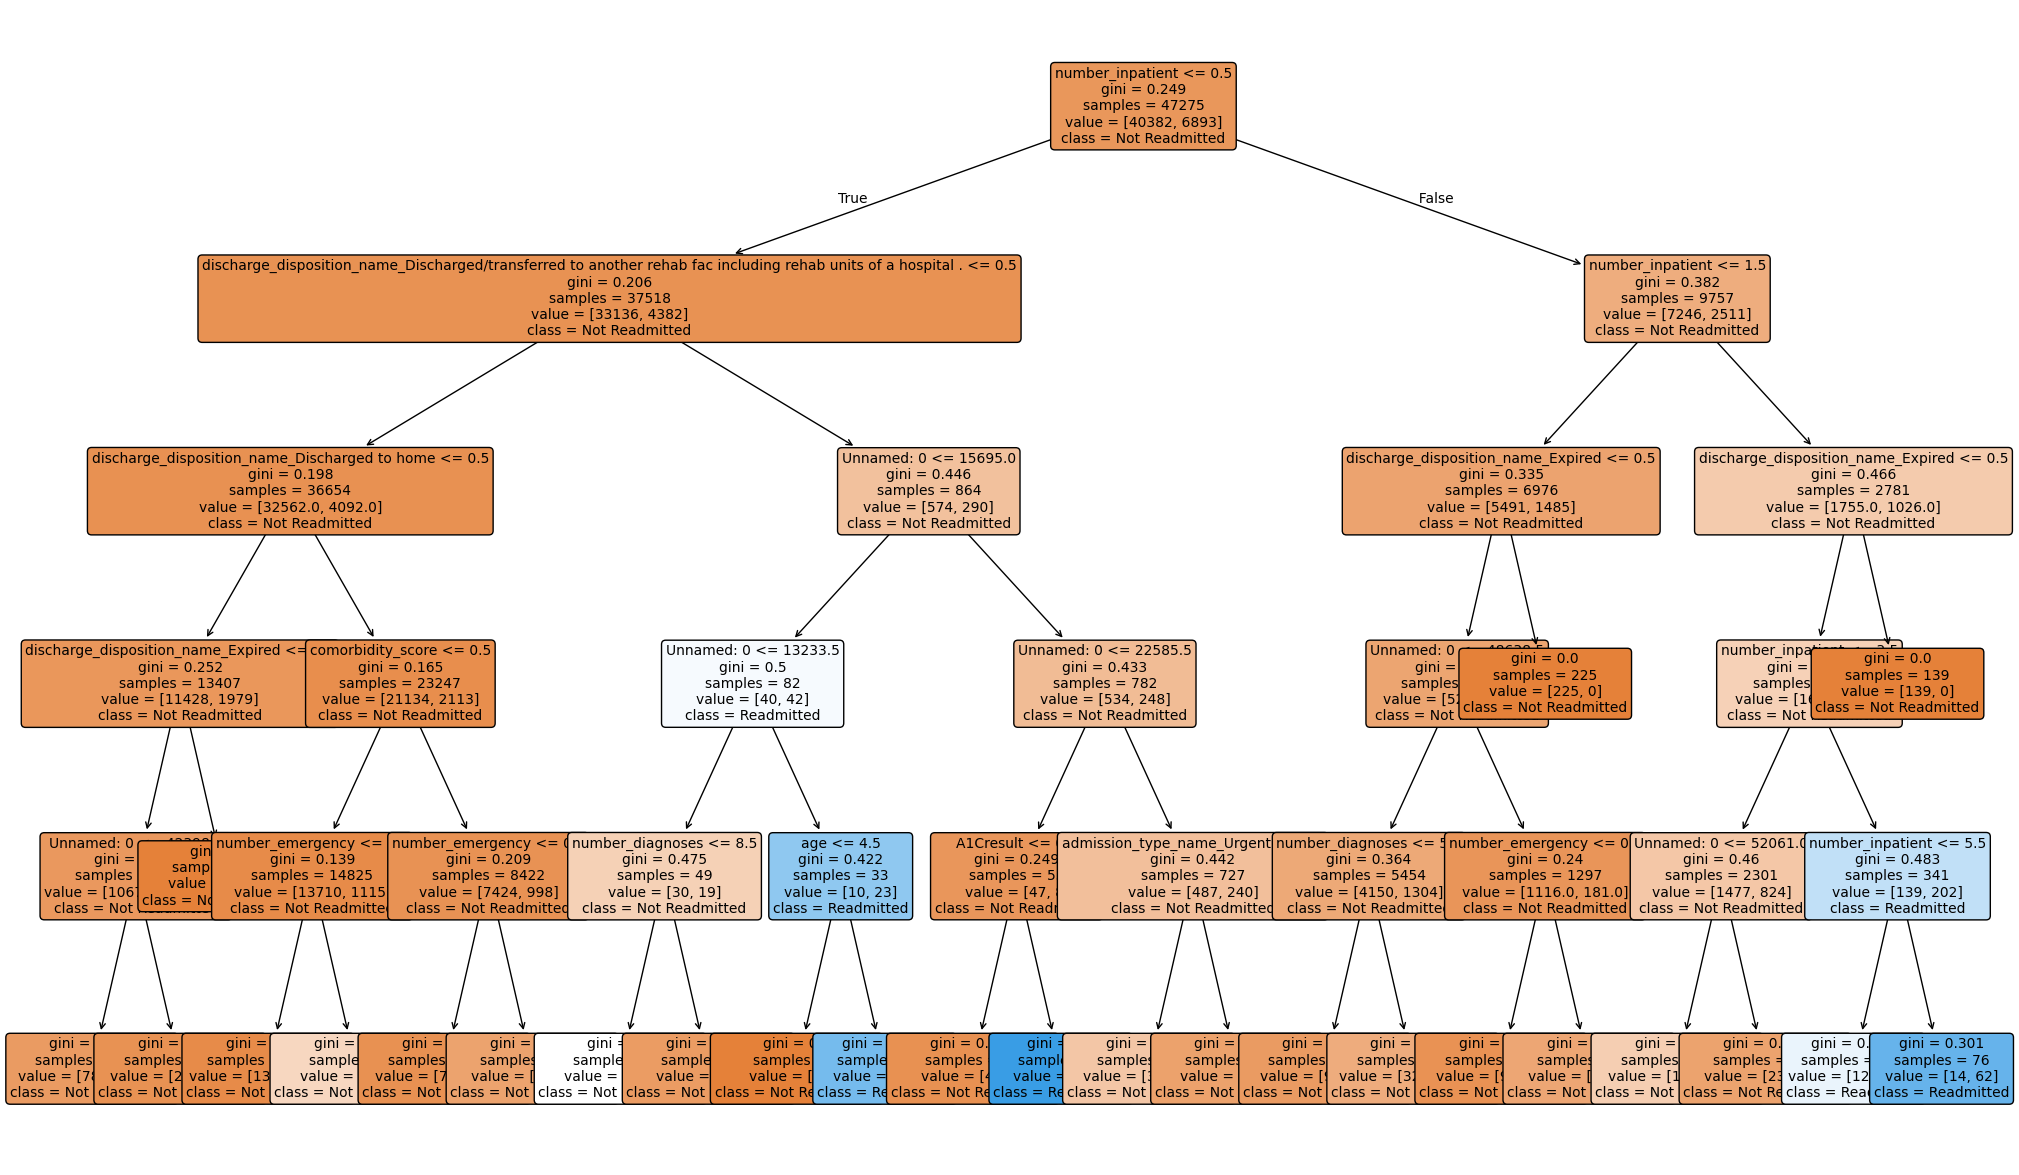

In [6]:
clf.fit(X_train, y_train)
print("✓ Decision tree model trained successfully!")

accuracy = clf.score(X_test, y_test)
print(f"\nModel Accuracy: {accuracy:.2f}")

plt.figure(figsize=(25, 15))
plot_tree(
    clf,
    filled=True,
    feature_names=X.columns,
    class_names=["Not Readmitted", "Readmitted"],
    rounded=True,
    fontsize=10
)